
# RF Kalibratie & Ruisbepaling (3× Raspberry Pi)

Deze notebook helpt je om tijdens een **kalibratietest** handmatig **dB-waarden** in te vullen voor **3 Raspberry Pi's** op vaste afstanden, een **logaritmische fit** te maken en hieruit de **ruis** en **padverlies-exponent** te schatten.

**Wat je doet:**
1. Vul in de cel **'🧩 Invoer: afstanden & metingen'** de dB-metingen in voor Pi1, Pi2 en Pi3 (twee metingen per afstand).
2. Run alle cellen ➜ je krijgt per Pi (en gecombineerd) de fitresultaten, grafieken en ruisschatting.

**Model & aannames**
We gebruiken het standaard log-afstandsmodel in dB:
\[
\text{RSSI}(dB) = C - 10 n \log_{10}(d) + \epsilon
\]
waarbij **n** de padverlies-exponent is en \(\epsilon\) ruis ~ N(0, \(\sigma^2\)).  
We schatten **n** en **C** via lineaire regressie op \(\log_{10}(d)\).  
**Ruisniveau**: we nemen **de standaardafwijking van de residuen** van de log-fit (per Pi en gecombineerd). Dit is doorgaans de beste keuze voor simulaties en verdere berekeningen.



## Benodigdheden
- Python, NumPy, Pandas, Matplotlib (zijn standaard aanwezig in deze omgeving).
- Geen internet of extra pakketten nodig.


In [7]:

# 🧩 Invoer: afstanden & metingen
# -------------------------------------------------
# ➜ Vul HIER je dB-metingen in.
#    Voor elke Pi geef je per afstand TWEE metingen op.
#    Formaat per Pi: list van [m1, m2] paren in dezelfde volgorde als 'distances_m'.
#
#    Voorbeeld:
#    - distances_m = [1.0, 1.5, 2.0]
#    - pi1_db = [[-45.2, -45.0], [-49.1, -49.4], [-52.3, -52.0]]
#
# ✳️ Afstanden (meters): standaard 1m t/m 7m met stap 0.5
distances_m = [0.5,1,1.3,1.5,1.7,2,2.2,2.5,2.7,3,3.5,4,5,6,8,10]

# ✳️ Metingen invullen (dB). Laat de placeholder-waarden niet staan; vervang ze door je echte data.
#    Zorg dat lengte van elke pi*_db gelijk is aan len(distances_m), en elk element is een lijst/tuple van 2 metingen.
#    Plaats hier je echte dB-metingen (negatieve getallen zijn gebruikelijk voor RSSI).

pi1_db = [
    [-45.0, -45.3],
    [-48.9, -49.2],
    [-51.8, -52.1],
    [-54.0, -54.4],
    [-55.6, -55.3],
    [-57.0, -56.8],
    [-58.2, -58.4],
    [-60.0, -59.7],
    [-61.5, -61.8],
    [-62.9, -63.1],
    [-57.0, -56.8],
    [-58.2, -58.4],
    [-60.0, -59.7],
    [-61.5, -61.8],
    [-62.9, -63.1],
    [-62.9, -63.1]
]

pi2_db = [
    [-44.7, -45.1],
    [-48.5, -48.7],
    [-51.6, -51.9],
    [-53.8, -54.2],
    [-55.1, -55.0],
    [-56.7, -56.5],
    [-58.0, -58.1],
    [-59.6, -59.9],
    [-61.2, -61.4],
    [-62.5, -62.7],
    [-57.0, -56.8],
    [-58.2, -58.4],
    [-60.0, -59.7],
    [-61.5, -61.8],
    [-62.9, -63.1],
    [-62.9, -63.1]
]

pi3_db = [
    [-45.3, -45.0],
    [-49.0, -49.0],
    [-52.0, -51.8],
    [-54.3, -54.1],
    [-55.8, -55.9],
    [-57.2, -57.0],
    [-58.5, -58.6],
    [-60.1, -60.3],
    [-61.7, -61.6],
    [-63.0, -63.2],
    [-57.0, -56.8],
    [-58.2, -58.4],
    [-60.0, -59.7],
    [-61.5, -61.8],
    [-62.9, -63.1],
    [-62.9, -63.1]
]

# --- Validatie van input ---
import numpy as np

def _validate_input(distances, *pi_lists):
    assert len(distances) >= 3, "Minimaal 3 afstanden nodig voor een zinvolle fit."
    for idx, lst in enumerate(pi_lists, start=1):
        assert len(lst) == len(distances), f"Pi{idx}: aantal afstanden ({len(lst)}) moet gelijk zijn aan len(distances) ({len(distances)})."
        for j, pair in enumerate(lst):
            assert isinstance(pair, (list, tuple)) and len(pair) == 2, f"Pi{idx}: afstand index {j} moet 2 metingen hebben (lijst/tuple van lengte 2)."
            assert all(np.isfinite(v) for v in pair), f"Pi{idx}: niet-finite waarde gevonden bij afstand index {j}."

_validate_input(distances_m, pi1_db, pi2_db, pi3_db)

print("✅ Invoer OK — je kunt verder met de analyses hieronder.")


✅ Invoer OK — je kunt verder met de analyses hieronder.


In [8]:

import numpy as np
import pandas as pd
import math

def average_pairs(pairs_list):
    """Neem het gemiddelde van elk [m1, m2]-paar.
    Returns: np.array van shape (N,)
    """
    arr = np.array(pairs_list, dtype=float)
    return arr.mean(axis=1)

def flatten_pairs(pairs_list):
    """Maak van [[m1,m2], ...] een 1D array [m1, m2, m1, m2, ...] in dezelfde volgorde als distances.
    """
    arr = np.array(pairs_list, dtype=float)
    return arr.reshape(-1)

def log10_distances_m(distances):
    d = np.array(distances, dtype=float)
    if np.any(d <= 0):
        raise ValueError("Afstanden moeten > 0 m zijn.")
    return np.log10(d)

def fit_log_distance_model(distances_m, rssi_db):
    """
    Past lineaire regressie toe: y = c0 + c1 * log10(d)
    Retourneert dict met: c0, c1, n (padverlies-exponent), sigma_resid, R2, y_pred, resid
    """
    x = log10_distances_m(distances_m)
    y = np.array(rssi_db, dtype=float)

    X = np.column_stack([np.ones_like(x), x])  # [1, log10(d)]
    # OLS: beta = (X^T X)^(-1) X^T y
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    c0, c1 = beta[0], beta[1]

    y_pred = X @ beta
    resid = y - y_pred
    # sigma = standaardafwijking residuen (MLE/normale OLS schatting met N-2 vrijheidsgraden)
    dof = max(1, len(y) - 2)
    sigma = math.sqrt(np.sum(resid**2) / dof)

    # R^2
    ss_tot = np.sum((y - y.mean())**2)
    ss_res = np.sum(resid**2)
    R2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # In het log-afstandsmodel: y = C - 10 n log10(d)  ==> c1 = -10 n  ==> n = -c1/10
    n = -c1 / 10.0

    return {
        "c0": float(c0),
        "c1": float(c1),
        "n": float(n),
        "sigma_resid": float(sigma),
        "R2": float(R2),
        "y_pred": y_pred,
        "resid": resid,
    }

def duplicate_noise_std(pairs_list):
    """Schat 'meetruis' uit duplicaten per afstand (std van m1,m2, dan gemiddeld over afstanden).
    Retourneert de wortel van de gemiddelde variantie over alle afstanden.
    """
    arr = np.array(pairs_list, dtype=float)  # shape (N, 2)
    per_dist_var = np.var(arr, axis=1, ddof=1)  # variantie van [m1,m2] per afstand
    per_dist_var = np.where(np.isfinite(per_dist_var), per_dist_var, 0.0)
    # Gemiddelde variantie over afstanden → daarna wortel
    return float(np.sqrt(per_dist_var.mean()))

print("🔧 Hulpfuncties geladen.")


🔧 Hulpfuncties geladen.


In [9]:

# 📊 Analyse per Pi
import pandas as pd

logs = []
results = {}

for label, data in [("Pi1", pi1_db), ("Pi2", pi2_db), ("Pi3", pi3_db)]:
    y_avg = average_pairs(data)
    fit = fit_log_distance_model(distances_m, y_avg)
    dup_sigma = duplicate_noise_std(data)
    results[label] = {
        **{k: v for k, v in fit.items() if k in ["c0","c1","n","sigma_resid","R2"]},
        "sigma_duplicate": dup_sigma,
    }
    logs.append({
        "Pi": label,
        "C (intercept)": fit["c0"],
        "slope c1": fit["c1"],
        "padverlies n": fit["n"],
        "sigma resid (dB)": fit["sigma_resid"],
        "sigma dup (dB)": dup_sigma,
        "R^2": fit["R2"],
    })

df_per_pi = pd.DataFrame(logs).set_index("Pi").round(4)
from IPython.display import display

display(df_per_pi)

print("✅ Resultaten per Pi berekend en weergegeven.")


,C (intercept),slope c1,padverlies n,sigma resid (dB),sigma dup (dB),R^2
Pi,,,,,,
Pi1,-51.6618,-13.6821,1.3682,2.4391,0.1904,0.7958
Pi2,-51.3403,-14.0172,1.4017,2.3621,0.1785,0.8135
Pi3,-51.7568,-13.6343,1.3634,2.5185,0.1436,0.7840


✅ Resultaten per Pi berekend en weergegeven.


In [10]:

# 📈 Gecombineerde analyse (alle Pi's samen)
# We middelen eerst per afstand per Pi (zodat elke Pi gelijke weging krijgt),
# en stapelen dan de drie Pi-reeksen onder elkaar in één regressie.

y_avg_pi1 = average_pairs(pi1_db)
y_avg_pi2 = average_pairs(pi2_db)
y_avg_pi3 = average_pairs(pi3_db)

# Stapel vectoren: [Pi1; Pi2; Pi3]
y_all = np.concatenate([y_avg_pi1, y_avg_pi2, y_avg_pi3], axis=0)
d_all = distances_m * 3  # herhaal afstanden 3×

fit_all = fit_log_distance_model(d_all, y_all)

# Voor referentie: ruisschatting uit duplicaten (gemiddeld over Pi's)
sigma_dup_all = np.mean([duplicate_noise_std(pi1_db),
                         duplicate_noise_std(pi2_db),
                         duplicate_noise_std(pi3_db)])

import pandas as pd
df_combined = pd.DataFrame([{
    "C (intercept)": fit_all["c0"],
    "slope c1": fit_all["c1"],
    "padverlies n": fit_all["n"],
    "sigma resid (dB)": fit_all["sigma_resid"],
    "sigma dup gem. (dB)": sigma_dup_all,
    "R^2": fit_all["R2"],
}]).round(4)

from IPython.display import display
display(df_combined)  # of df_per_pi, afhankelijk van waar je bent

print("✅ Gecombineerde fit uitgevoerd.")


,C (intercept),slope c1,padverlies n,sigma resid (dB),sigma dup gem. (dB),R^2
0,-51.5863,-13.7779,1.3778,2.3355,0.1708,0.7974


✅ Gecombineerde fit uitgevoerd.


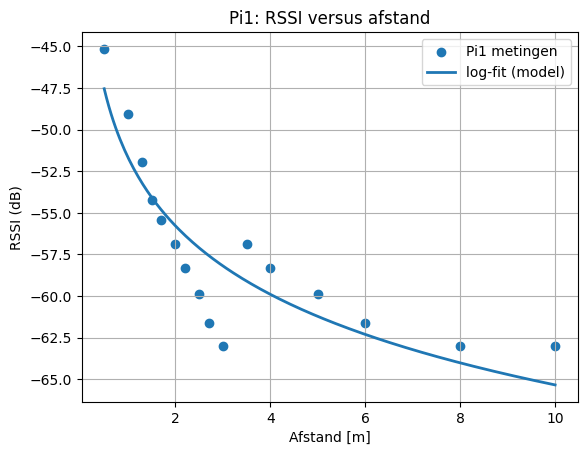

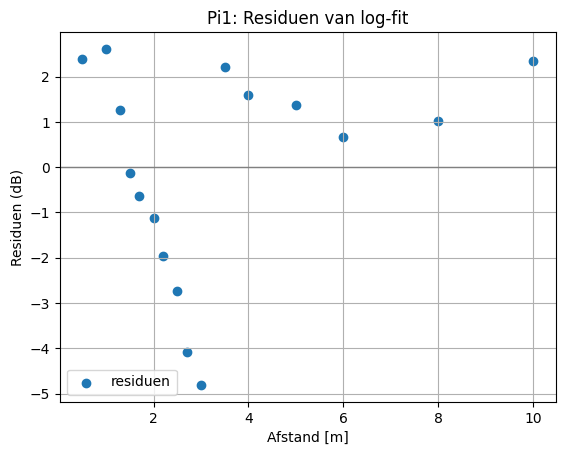

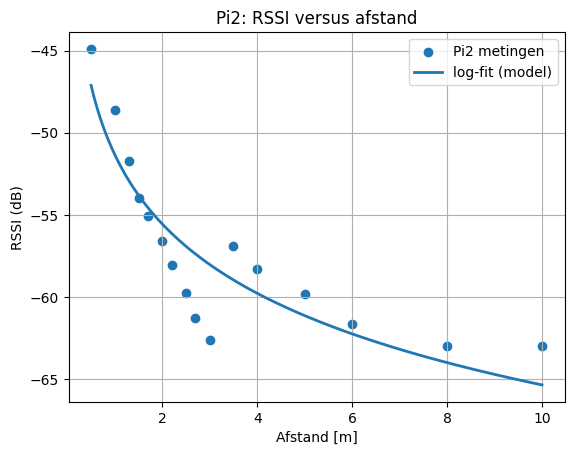

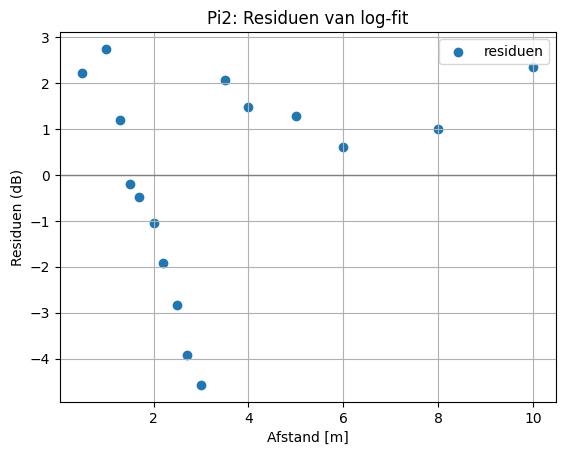

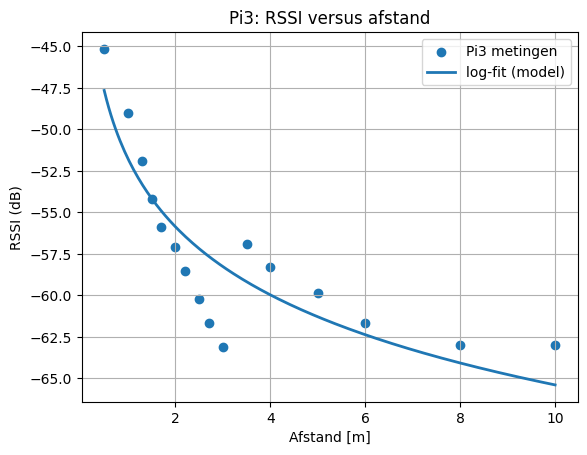

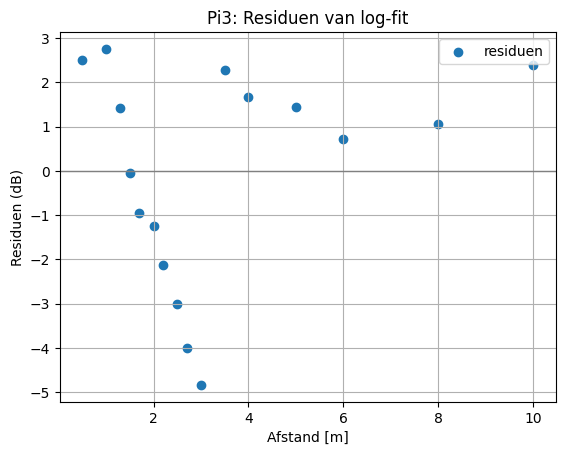

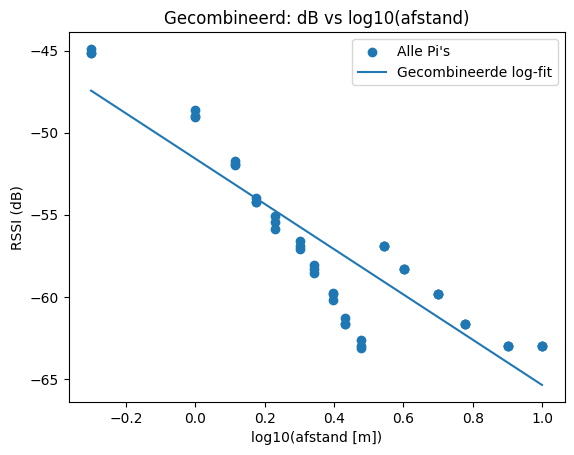

In [13]:

# 🖼️ Grafieken
# Regels: gebruik Matplotlib, één grafiek per figuur, geen kleurenstijlen forceren.

import matplotlib.pyplot as plt
import numpy as np

def plot_fit(distances, y_avg, label):
    """
    Plot RSSI (dB) tegen afstand (m) met logaritmische fit,
    maar x-as blijft lineair in meters (geen log10(x) op as).
    """
    res = fit_log_distance_model(distances, y_avg)

    # Maak gladde curve voor de fit (meer punten, netjes krom)
    d_smooth = np.linspace(min(distances), max(distances), 200)
    y_fit = res["c0"] + res["c1"] * np.log10(d_smooth)

    plt.figure()
    plt.scatter(distances, y_avg, label=f"{label} metingen")
    plt.plot(d_smooth, y_fit, label="log-fit (model)", linewidth=2)
    plt.xlabel("Afstand [m]")
    plt.ylabel("RSSI (dB)")
    plt.title(f"{label}: RSSI versus afstand")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_residuals(distances, y_avg, label):
    """
    Plot residuen (meting - model) tegen afstand (lineaire x-as).
    Zo zie je of er systematische fouten over afstand zitten.
    """
    res = fit_log_distance_model(distances, y_avg)
    plt.figure()
    plt.scatter(distances, res["resid"], label="residuen")
    plt.axhline(0.0, color="gray", linewidth=1)
    plt.xlabel("Afstand [m]")
    plt.ylabel("Residuen (dB)")
    plt.title(f"{label}: Residuen van log-fit")
    plt.legend()
    plt.grid(True)
    plt.show()

# Per Pi
for label, data in [("Pi1", pi1_db), ("Pi2", pi2_db), ("Pi3", pi3_db)]:
    y_avg = average_pairs(data)
    plot_fit(distances_m, y_avg, label)
    plot_residuals(distances_m, y_avg, label)

# Gecombineerd plot (alle Pi punten samen)
plt.figure()
x_all = np.log10(distances_m * 3)
plt.scatter(x_all, np.concatenate([average_pairs(pi1_db), average_pairs(pi2_db), average_pairs(pi3_db)]), label="Alle Pi's")
res_all = fit_log_distance_model(distances_m * 3, np.concatenate([average_pairs(pi1_db), average_pairs(pi2_db), average_pairs(pi3_db)]))
# Voor de lijn: sorteerde x op unieke log10(d) waarden met voorspelde lijn voor de gemiddelden per afstand (gemiddeld over Pi's kan ook)
x_line = np.log10(distances_m)
X_line = np.column_stack([np.ones_like(x_line), x_line])
y_line = X_line @ np.array([res_all["c0"], res_all["c1"]])
plt.plot(x_line, y_line, label="Gecombineerde log-fit")
plt.xlabel("log10(afstand [m])")
plt.ylabel("RSSI (dB)")
plt.title("Gecombineerd: dB vs log10(afstand)")
plt.legend()
plt.show()


In [15]:

# 💾 Export van parameters voor verdere berekeningen (optioneel)
# Slaat per Pi en gecombineerd de fitparameters op in JSON voor later gebruik.

import json
from pathlib import Path

export = {
    "per_pi": {},
    "combined": {},
}

# Per Pi
for label, data in [("Pi1", pi1_db), ("Pi2", pi2_db), ("Pi3", pi3_db)]:
    fit = fit_log_distance_model(distances_m, average_pairs(data))
    export["per_pi"][label] = {
        "C_intercept": fit["c0"],
        "slope_c1": fit["c1"],
        "path_loss_n": fit["n"],
        "sigma_residual_db": fit["sigma_resid"],
        "R2": fit["R2"],
        "sigma_duplicate_db": duplicate_noise_std(data),
    }

# Combined
y_all = np.concatenate([average_pairs(pi1_db), average_pairs(pi2_db), average_pairs(pi3_db)], axis=0)
d_all = distances_m * 3
fit_all = fit_log_distance_model(d_all, y_all)

export["combined"] = {
    "C_intercept": fit_all["c0"],
    "slope_c1": fit_all["c1"],
    "path_loss_n": fit_all["n"],
    "sigma_residual_db": fit_all["sigma_resid"],
    "R2": fit_all["R2"],
    "sigma_duplicate_mean_db": float(np.mean([duplicate_noise_std(pi1_db), duplicate_noise_std(pi2_db), duplicate_noise_std(pi3_db)])),
}

out_path = Path("rf_calibration_params.json")
out_path.write_text(json.dumps(export, indent=2))
print(f"✅ Parameters geëxporteerd naar: {out_path}")


✅ Parameters geëxporteerd naar: rf_calibration_params.json



## Hoe gebruik je deze parameters verder?
- **Padverlies-exponent `n`** en **intercept `C`** kun je direct gebruiken om verwachte dB op afstand d te simuleren met:  
  \( \hat{y}(d) = C - 10n\log_{10}(d) \).
- **Ruis** gebruik je als Gaussiaanse verstoring (in dB) met standaardafwijking `sigma_resid`.
- De **duplicaat-ruis** (`sigma_duplicate_db`) geeft je een beeld van pure meetvariatie op exact dezelfde afstand (handig voor instrumentruis).
- Voor realistische simulaties: neem **sigma = sigma_resid**. Dat dekt zowel instrumentruis als modelafwijkingen.
